<a href="https://colab.research.google.com/github/HyeonhoonLee/TSA_pandas/blob/master/10_ARIMA_and_Seasonal_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ARIMA and Seasonal ARIMA

## Autoregressive Integrated Moving Averages
**1. 개요** 
* ARIMA는 개발된지 오래된 방법으로 시계열 데이터 분석을 위해 이해해야 하는 중요한 모델링 또는 예측 기법입니다.
* Stationary vs. Non-stationary time series
* Seasonal vs. Non-seasonal ARIMA
  - Non-seasonal ARIMA : ARIMA(p, d, q)
  - Seasonal ARIMA : ARIMA(p, d, q)(P, D, Q)m
* ARIMA
  - Autoregressive - AR(p)
  - Integrated - I(d)
  - Moving Average - MA(q)



**2. 방법**

* 일반적으로 다음 프로세스를 따라 ARIMA 모델을 만듭니다:
  * 시계열 데이터 시각화
  * 시계열 데이터를 stationary 특성화
  * Correlation 과 AutoCorrelation 챠트 플로팅
  * ARIMA 모델 생성
  * 만들어진 모델로 예측 수행

순서대로 다뤄봅시다.

## Stationary vs. Non-Stationary

1. Stationary 데이터 특성
 * 연속되는 숫자들의 평균(mean)이 time invariant
 * 연속되는 숫자들의 분산(variance)이 time invariant
 * 연속되는 숫자들의 공분산(covariance)이 time invariant

2. Stationary test
 * ARIMA 모델은 시계열 데이터가 stationary 특성을 보일 때 효과적이므로 데이터가 stationary 특성을 보이는지 확인할 수 있어야 합니다.

3. Differencing
 * 시계열 데이터가 Non-Stationary 하다면 초기 differencing 작업("Integrated")을 한 번 이상 적용해서 데이터를 stationary 하게 만드는 단계가 필요합니다.

*(이후는 ppt파일 참고)*

## Step 1: 데이터 읽기와 포매팅

월별 우유 소비 데이터를 사용합니다. 데이터는 [Data Market](https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line) 에서 다운받아 저장해놓은 CSV 파일을 읽습니다.

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv('/content/drive/My Drive/Tacademy/TSA_pandas/data/monthly-milk-production.csv', index_col='Month', parse_dates=True)

In [4]:
df.head()

,pounds per cow
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


## Step 2: Visualize the Data

pandas 내장 플로팅 함수들로 시계열 데이터를 시각화 해봅니다.

In [5]:
timeseries = df['pounds per cow']

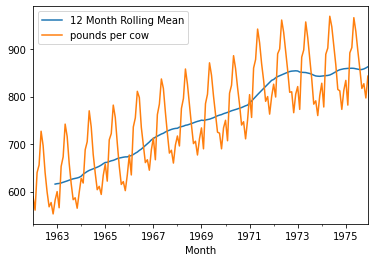

In [6]:
## trend를 확인하기 위해 mean으로 그래프를 그려본다.
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.plot()
plt.legend()

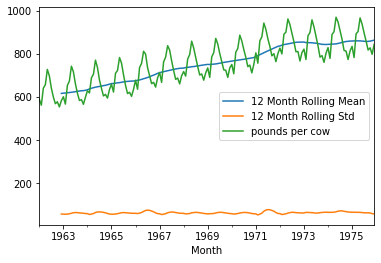

In [7]:
## Variance가 똑같이 유지가 되고 있는지를 확인하기 위해 std()를 구한다.
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

## Decomposition

ETS decomposition 을 통해서 시계열 데이터를 구성하는 요소들을 확인할 수 있습니다.

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
decomposition = seasonal_decompose(df['pounds per cow'])

<Figure size 432x288 with 0 Axes>

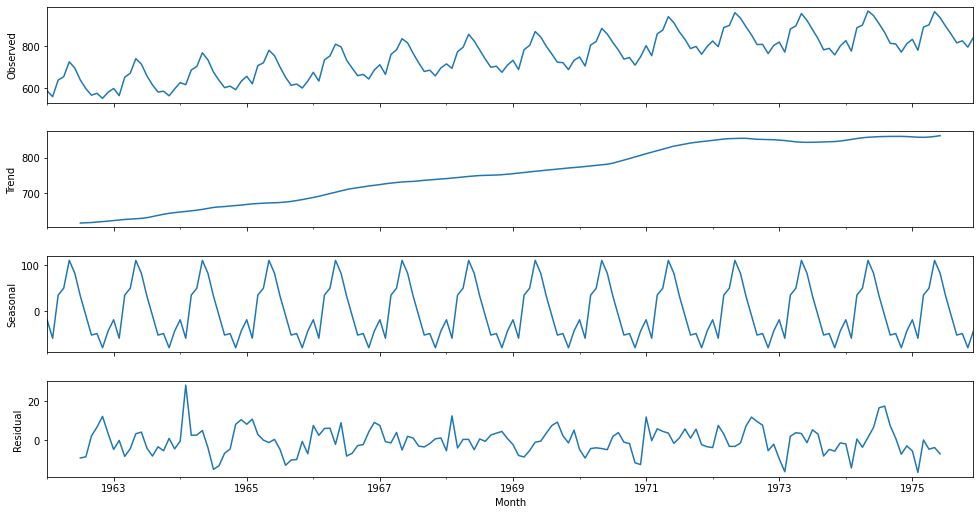

In [10]:
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,8)

In [11]:
# 지금 우리가 하고자하는 것은,
# Residual에서 패턴을 찾은 다음, trend와 seasonal에 더해줌으로써, 
# data를 정확하게 prediction하는 과정을 ARIMA를 통해서 구현을 하려고 하는 것.

## Testing for Stationarity

시계열 데이터의 Stationarity 특성을 시험하기 위해 Augmented [Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) [unit root test](https://en.wikipedia.org/wiki/Unit_root_test) 를 사용합니다.

Augmented Dicky-Fuller (ADF) test 는 시계열 데이터 샘플에 단위근(unit root)이 존재한다는 귀무가설을 시험하므로써 대립가인 stationarity 또는 trend-stationarity 여부를 확인합니다. 

시계열 데이터에 unit root 가 있어 non-stationary 하다는 귀무가설 H0 를 accept 할지, 또는 이를 reject 하면서 시계열 데이터에 unit root 가 없고 stationary 하다는 대립가설을 채택할지를 실험하는 것입니다.

결국 결과값 p-value 로 결정하게 됩니다.

* p-value 값이 작을 때 (≤ 0.05) 귀무가설을 reject 하고 데이터는 stationary 함

* p-value 값이 클 (> 0.05) 귀무가설을 accept 하고 데이터는 non-stationary 함

가공한 데이터에 ADF 테스트를 해봅시다:

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
result = adfuller(df['pounds per cow'])

In [14]:
# result 중 인덱스 1번째가 p값.
result

(-1.3038115874221248,
 0.6274267086030337,
 13,
 154,
 {'1%': -3.473542528196209,
  '10%': -2.576878053634677,
  '5%': -2.880497674144038},
 1115.1730447395112)

In [15]:
# 반복적인 사용을 위해 함수화 합니다.
def adf_check(ts):
    result = adfuller(ts)
    if result[1] <= 0.05:
        print('Stationary {}'.format(result[1]))
    else:
        print('Non-Stationary {}'.format(result[1]))

In [16]:
adf_check(df['pounds per cow'])

Non-Stationary 0.6274267086030337


## Differencing

시계열 데이터에 대한 1차(first) difference 는 다음 스탭으로의 한 차원(시간단위) 만큼의 변화값의 series 입니다. pandas 를 이용하면 아주 differencing 할 수 있습니다. 2차, 3차, 그보다 더 높은 차원의 differencing 을 시도해보고 stationary 한 차원을 찾습니다.


In [17]:
## 보통 1, 2차원 내에 끝난다.
## 3차원 이상을 해도 없어지지 않는다는 건, 원래 data가 trend나 seasonality가 없다는 의미이기 때문.

#### First Difference

In [18]:
df['1st diff'] = df['pounds per cow'] - df['pounds per cow'].shift(1)

In [19]:
df.head()

,pounds per cow,1st diff
Month,,
1962-01-01,589,NaN
1962-02-01,561,-28.0
1962-03-01,640,79.0
1962-04-01,656,16.0
1962-05-01,727,71.0


In [20]:
# 첫번째 행에서 NaN이 발생할 수 밖에 없기 때문에, 결측치행을 제거해준다.
adf_check(df['1st diff'].dropna())

Stationary 0.030068004001782334


In [21]:
## 0.05보다 작으니까, 1st diff를 쓰면 된다.

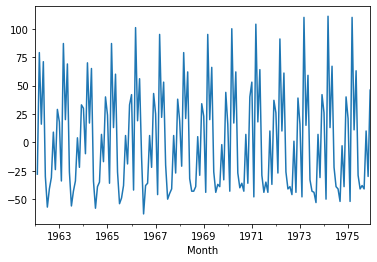

In [22]:
df['1st diff'].plot()

#### Second Differencing

In [23]:
df['2nd diff'] = df['1st diff'] - df['1st diff'].shift(1)

In [24]:
adf_check(df['2nd diff'].dropna())

Stationary 1.1126989332082667e-26


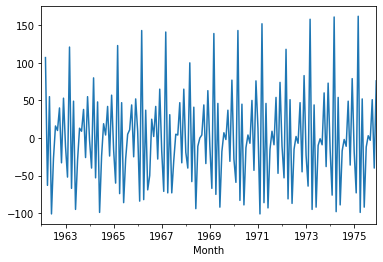

In [25]:
df['2nd diff'].plot()

#### Seasonal Difference

In [26]:
df['seasonal diff'] = df['pounds per cow'] - df['pounds per cow'].shift(12)

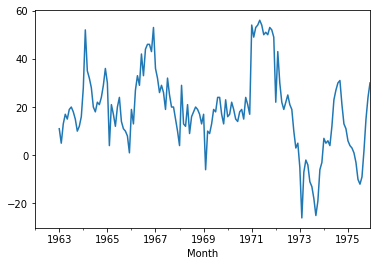

In [27]:
df['seasonal diff'].plot()

In [28]:
adf_check(df['seasonal diff'].dropna())

Non-Stationary 0.16079880527711382


In [29]:
## 이런식으로 계속 차수를 높이는 것 보다는, 
## 다시 돌아가서 1st diff.에 대한 seasonal diff.를 하는 것도 방법이다.

결과상 seasonality 만 아니라 trend 도 가지고 있으므로 1차 differencing 한 데이터에 대한 seasonal differencing 을 수행해봅니다.

#### Seasonal First Difference

In [30]:
df['seasonal 1st diff'] = df['1st diff'] - df['1st diff'].shift(12)

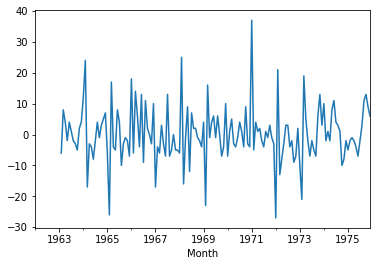

In [31]:
df['seasonal 1st diff'].plot()

In [32]:
adf_check(df['seasonal 1st diff'].dropna())

Stationary 1.865423431878876e-05


In [31]:
## 이로써 first diff.니까 d=1, Seasonal diff.을 1번했으니까 D=1

이와 같은 과정에서 d=1, D=1 의 파라메터를 찾았습니다.

# Autocorrelation and Partial Autocorrelation Plots

ARIMA 의 p,q 파라메터를 찾기 위해 PACF 와 ACF 플롯을 참조합니다.

플롯에 대한 해석은 간단하지만은 않은데, [여기](http://people.duke.edu/~rnau/arimrule.htm) 와 [여기](https://people.duke.edu/~rnau/411arim3.htm) 에 ACF 와 PACF 를 해석하는 방법에 대한 정보가 자세히 나와있으니 참고하십시오. 

### Autocorrelation Interpretation

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

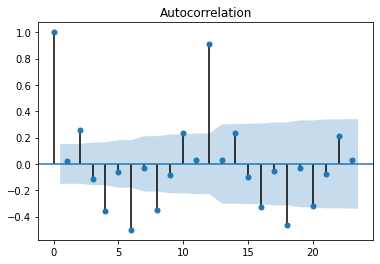

In [39]:
plot_acf(df['1st diff'].dropna());

In [ ]:
## 아래 그림이 원래 제시되었던 것. 
## 계속 반복적으로 위 아래로 correlation이 보이므로, q는 그냥 0으로 한다.

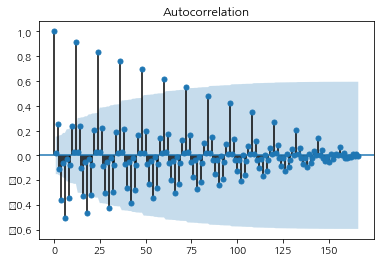

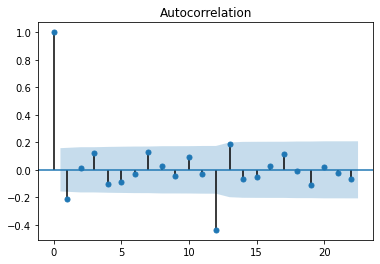

In [34]:
plot_acf(df['seasonal 1st diff'].dropna());

In [ ]:
## 아래 그림이 원래 제시되었던 것.
## 아래 그래프에서 lag(leg?) 1에서 correlation이 나왔으니, 대문가 Q 를 1 하나 늘려준다.
## 대신에 이 음수값 하나 이후로 계속 붙어서 막대기가 그려져 있으면 correlation이 있는 것이다.

## lag 0에서는 자기자신과의 회귀니까 당연히 1.0 값이 나온다.

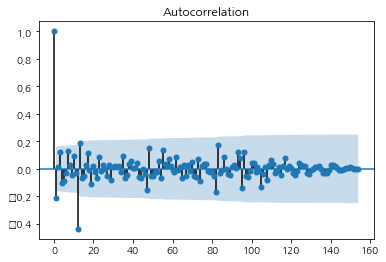

## Partial Autocorrelation

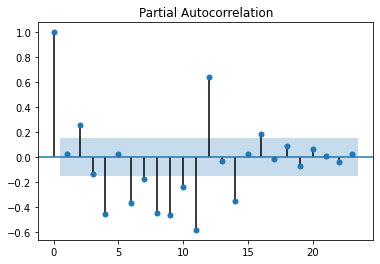

In [40]:
plot_pacf(df['1st diff'].dropna(), method='ywm');

In [ ]:
## 아래 그림이 원래 제시되었던 것.
## 초반에 음수값이 밀집해서 붙어있으므로 correlation이 있는 것이므로,
## 따로 Q값을 정하기가 어려워서 Q는 0으로 한다.

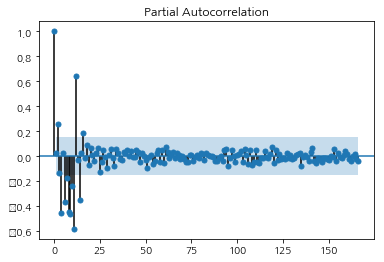

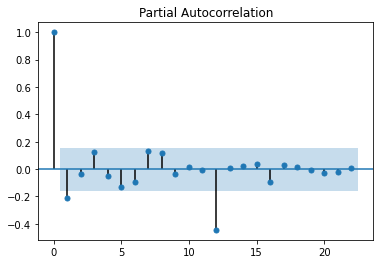

In [36]:
plot_pacf(df['seasonal 1st diff'].dropna(), method='ywm');

In [ ]:
## 아래 그림이 원래 제시되었던 것.
## 아래 그림처럼 PACF에서 lag(?) 1에서 음수 값이 하나 나오면, 대문자 P 하나 늘려주면 된다.

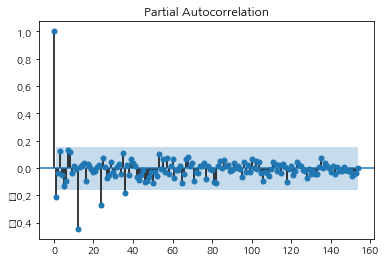

### Autocorrelation 과 Partial Autocorrelation 에 대한 요약

* AR 모델 판별은 대체로 PACF 를 통해 확인할 수 있습니다.
    * 이론적으로 PACF 는 AR 모델의 차수 이후 "shut off" 를 보입니다. "shut off"  되었다는 것은 partial autocorrelation 이 해당 지점 이후 0 과 같다는 의미입니다. 다른 말로, 0 아닌 partial autocorrelation 이 존재하는 차수가 AR 모델의 차수가 됩니다. 
    
* MA 모델에 대한 판별은 PACF 보다 ACF 더 명확히 확인됩니다.
    * MA 모델에 있어서 PACF 는 "shut off" 하지 않지만 0 을 향해 점진적으로 줄어듭니다. ACF 에 MA 모델이 좀 더 분명히 나타나는데, 모델과 관련된 lag 에 대해서만 0 아닌 autocorrelation 이 나타납니다.

## Seasonal ARIMA 모델 사용하기

In [41]:
model = sm.tsa.statespace.SARIMAX(df['pounds per cow'],
                                 order=(0,1,0),
                                 seasonal_order=(1,1,1,12))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [42]:
result = model.fit()

In [43]:
# 중요한 지표는 AIC와 BIC. 모델의 성능 혹은 단순함을 의미.
# AIC : Akaike’s information criterion
# BIC : Bayesian information criterion
print(result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     pounds per cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Thu, 10 Sep 2020   AIC                           1074.131
Time:                                    15:39:51   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

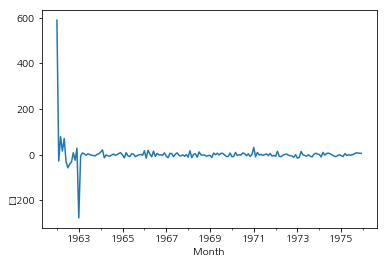

In [ ]:
# 아래 그래프는 training 하면서 계산된 residual이다.
# 시작부터 시계열 방향으로 계속 data를 fitting해가면서, 스스로 residual을 구해서
# residual이 적어지는 방향으로 coefficient를 계산한 것이다.
result.resid.plot()

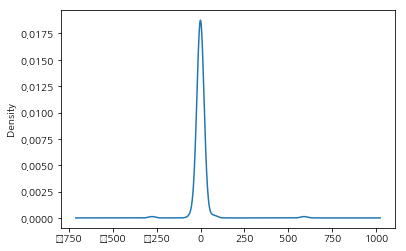

In [ ]:
# 아래 그래프를 통해 가우시안 분포를 확인함으로써, biased되지 않은 noise data라는 것을 알 수 있다.
# 이는 곧 모델 fitting이 잘 되었다는 것을 의미한다.
# 그러므로 이 fitting 된 모델을 이용하여 이후부터 prediction을 할 수 있다.
result.resid.plot(kind='kde')

## Prediction of Future Values

일단 생성된 모델이 이미 알고 있는 결과 대비 얼마나 좋은 예측 성능을 보여주는지 확인해봅시다:

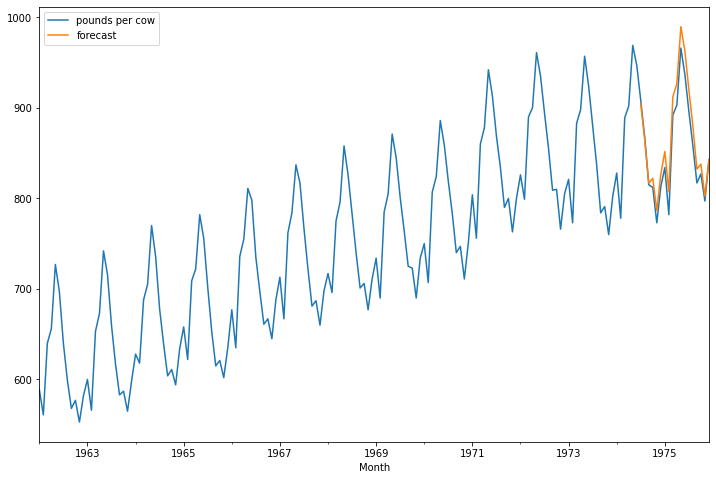

In [44]:
df['forecast'] = result.predict(start=150, end=168, dynamic=True)

df[['pounds per cow', 'forecast']].plot(figsize=(12,8))